# PCA/SVM methods for rearing detection

1. Organize the design matrix for PCA
2. Get the pattern for PCA

# 1. Load the data

# 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from base import MultiDaysBeaconPosition, BeaconPosition
from scipy.stats import sem
from utils.basic_utils import get_tags, joint_density_function
from sklearn.decomposition import PCA

from utils.baseline_method import continuous_detection 

In [2]:
root_path = '../Data/Raw/'
rat_id = 'FS10'
rat_subdirectories = glob(root_path+rat_id+'/*/' )

tags = get_tags(rat_subdirectories)

## 1.1 For one tag of rat

In [3]:
tag_id = 0
this_tag = BeaconPosition(rat_subdirectories[tag_id], tags[tag_id], True, True) #position data of this tag

In [4]:
unit_time = np.mean(this_tag.position_data[1:,0] - this_tag.position_data[:-1,0])
print(unit_time) # average time for a bin

0.016694419627324594


# 2. Detect rearing roughly (using threshold first)

In [64]:
# set the parameters
save_fig = False # whether save the fig for the results

T = 50
tau = 5
group_step = 5 # so that no overlap between taus

height_thresh = 0.6 # threshold for height/z to determine rearing

# get some important variables
xy_speed = np.insert(this_tag.speed,0,0) # speed on xy planar insert 0 at the beginning of the speed array to make the size same
z_speed = np.divide(this_tag.position_data[1:,3] - this_tag.position_data[:-1,3], this_tag.position_data[1:,0] - this_tag.position_data[:-1,0])
z_speed = np.insert(z_speed,0,0) # insert 0 at the beginning of the speed array to make the size same 

z = this_tag.position_data[:,3]

# organize k features that we're interested in
k = 4
all_feature_matrix = np.zeros((k, len(z)))

# normalize each feature, so that the scale of max value is 1
all_feature_matrix[0,:] = z
all_feature_matrix[1,:] = this_tag.position_data[:,6]
all_feature_matrix[2,:] = z_speed
all_feature_matrix[3,:] = xy_speed

In [11]:
def rearing_detection(z, height_thresh = 0.6):
    '''
    detect rearing by the height_thresh, if z[i]> = height_thresh, then the time of z[i] if rearing time
    z: array of height in time series
    height_thresh :threshold to determine the rearing
    
    return:
    r: array of index of rearing time
    '''
    
    return np.argwhere(z>= height_thresh).flatten()
    

In [12]:
def generate_tau_sample(before_matrix, tau = 10, step = 2, T = 200, k = 4):
    '''
    generate a matrix of tau length sample by slicing the window along the whole time series
    features: [n,k,T]
    
    n: number of rearing events
    k: number of the features interested in
    
    
    return : array in[n*m, tau*k], m is the number of slice of tau for T long period
    '''
    # determine the size of the final output
    
    # use a time window to slip along T and get slice of tau, combine different features horizontally, 

    num_slice = T//tau # if step = tau, no overlap
    num_events = before_matrix.shape[0]
    x_matrix = np.zeros((num_events * num_slice, tau * k))


    for i, end_idx in enumerate(np.arange(tau, T+1, step)):
        x_matrix[i*num_events: (i+1)*num_events, :] = np.hstack(np.transpose(before_matrix[:,:,end_idx - tau:end_idx],(1,0,2))) 
    
    
    return x_matrix

In [13]:
rearing_idx = rearing_detection(z, height_thresh= height_thresh)
whether_continue, rearing_periods = continuous_detection(rearing_idx, discontinu_tolerance= 10, total_tolerance= 20,seperate= True)

# rearing_periods: slice of different rearing events

In [110]:
# determine T tau
T = 100
tau = 5

In [111]:
# for each rearing event, get T length time before it
before_list = []
after_rearing = 150
for i,this_rearing in enumerate(rearing_periods):
    begin_idx = this_rearing[0]
    if (begin_idx - T >=0) & (begin_idx +after_rearing< all_feature_matrix.shape[-1]):
        before_list.append(all_feature_matrix[:,begin_idx - T: begin_idx])
before_matrix = np.asarray(before_list) # in shape [num_event, k, T]
num_events = before_matrix.shape[0]

In [112]:
before_matrix.shape

(187, 4, 100)

In [113]:
# for each rearing event, get more time aroung it 
after_rearing = 150 # bins
longer_array= np.zeros((num_events, k, T+after_rearing))
i = 0
rearing_begin_idxs = []
for this_rearing in rearing_periods:
    begin_idx = this_rearing[0]
    if begin_idx - T >=0:
        rearing_begin_idxs.append(begin_idx)
        longer_array[i,:,:] = all_feature_matrix[:,begin_idx - T: begin_idx + after_rearing]
        i+= 1
    

In [114]:
# use a time window to slip along T and get slice of tau, combine different features horizontally, 
x_matrix = generate_tau_sample(before_matrix, tau =tau, step = tau, T = T)
x_norm = (x_matrix - x_matrix.mean(axis=0))


# 3. Use PCA to detect the rearing period

In [115]:
# normalize x_matrix
x_norm = x_matrix - x_matrix.mean(axis=0)
pca = PCA(n_components= 10)
pca.fit(x_norm)

PCA(n_components=10)

In [116]:
eigen_vec = pca.components_
eigen_ratio = pca.explained_variance_ratio_

## 3.1 Plot resutls for first PC


[9.62444351e-01 2.38030733e-02 7.18118277e-03 3.77148052e-03
 2.60401330e-03 4.31245360e-05 3.11421585e-05 3.05438678e-05
 2.44959569e-05 2.02946400e-05]


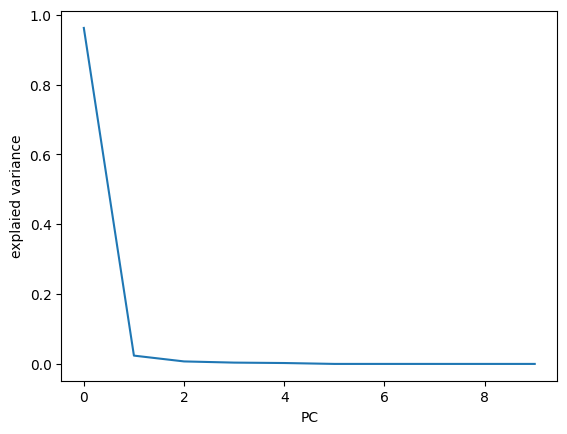

In [117]:
plt.plot(eigen_ratio)
plt.xlabel('PC')
plt.ylabel('explaied variance')
print(eigen_ratio)

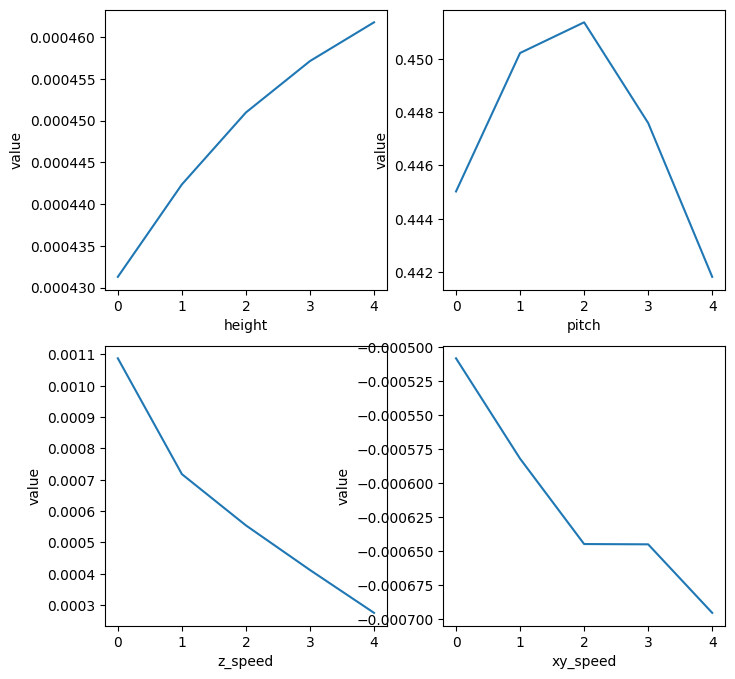

In [118]:
# Plot eigenvector resutls for first PC,
feature_labels = ['height', 'pitch','z_speed', 'xy_speed']
fig, axis = plt.subplots(2,2, figsize = (8,8))
axis = axis.flatten()

firt_pc = np.split(eigen_vec[0,:], k, axis = 0)

for i in np.arange(0,k):
   
    axis[i].plot(firt_pc[i])

    # axis[i].legend()
    axis[i].set_xlabel(feature_labels[i])
    axis[i].set_ylabel('value')
    

# 3.2 need to use pca resutls to determine rearing ...

In [119]:
# project
proj_x = x_norm @ eigen_vec[0,:]

In [122]:
reshape_x = np.reshape(proj_x, (-1,num_events))
pca_thresh = -8

(2, 20)


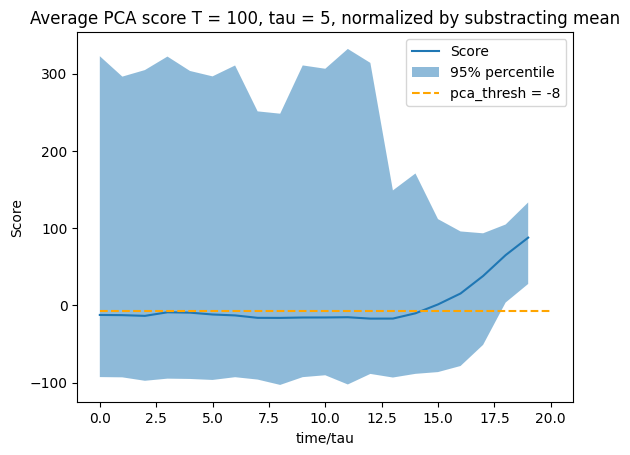

In [123]:
plt.plot(reshape_x.mean(axis = 1),label = 'Score')
x_percen = np.percentile(reshape_x, [2.5,97.5],axis = 1)
print(x_percen.shape)
plt.fill_between(np.arange(0,int(T//tau)), x_percen[0,:],x_percen[1,:], alpha = 0.5,label = '95% percentile')
plt.hlines(y = pca_thresh, xmin = 0, xmax= int(int(T//tau)), label='pca_thresh = %d'%pca_thresh, linestyles='dashed',color = 'orange')
title = 'Average PCA score T = %d, tau = %d, normalized by substracting mean'%(T, tau)
plt.title(title)
plt.xlabel('time/tau')
plt.ylabel('Score')
plt.legend()
plt.savefig('results/PCA_method/%s/%s.png'%(rat_id, title), format ='png',)

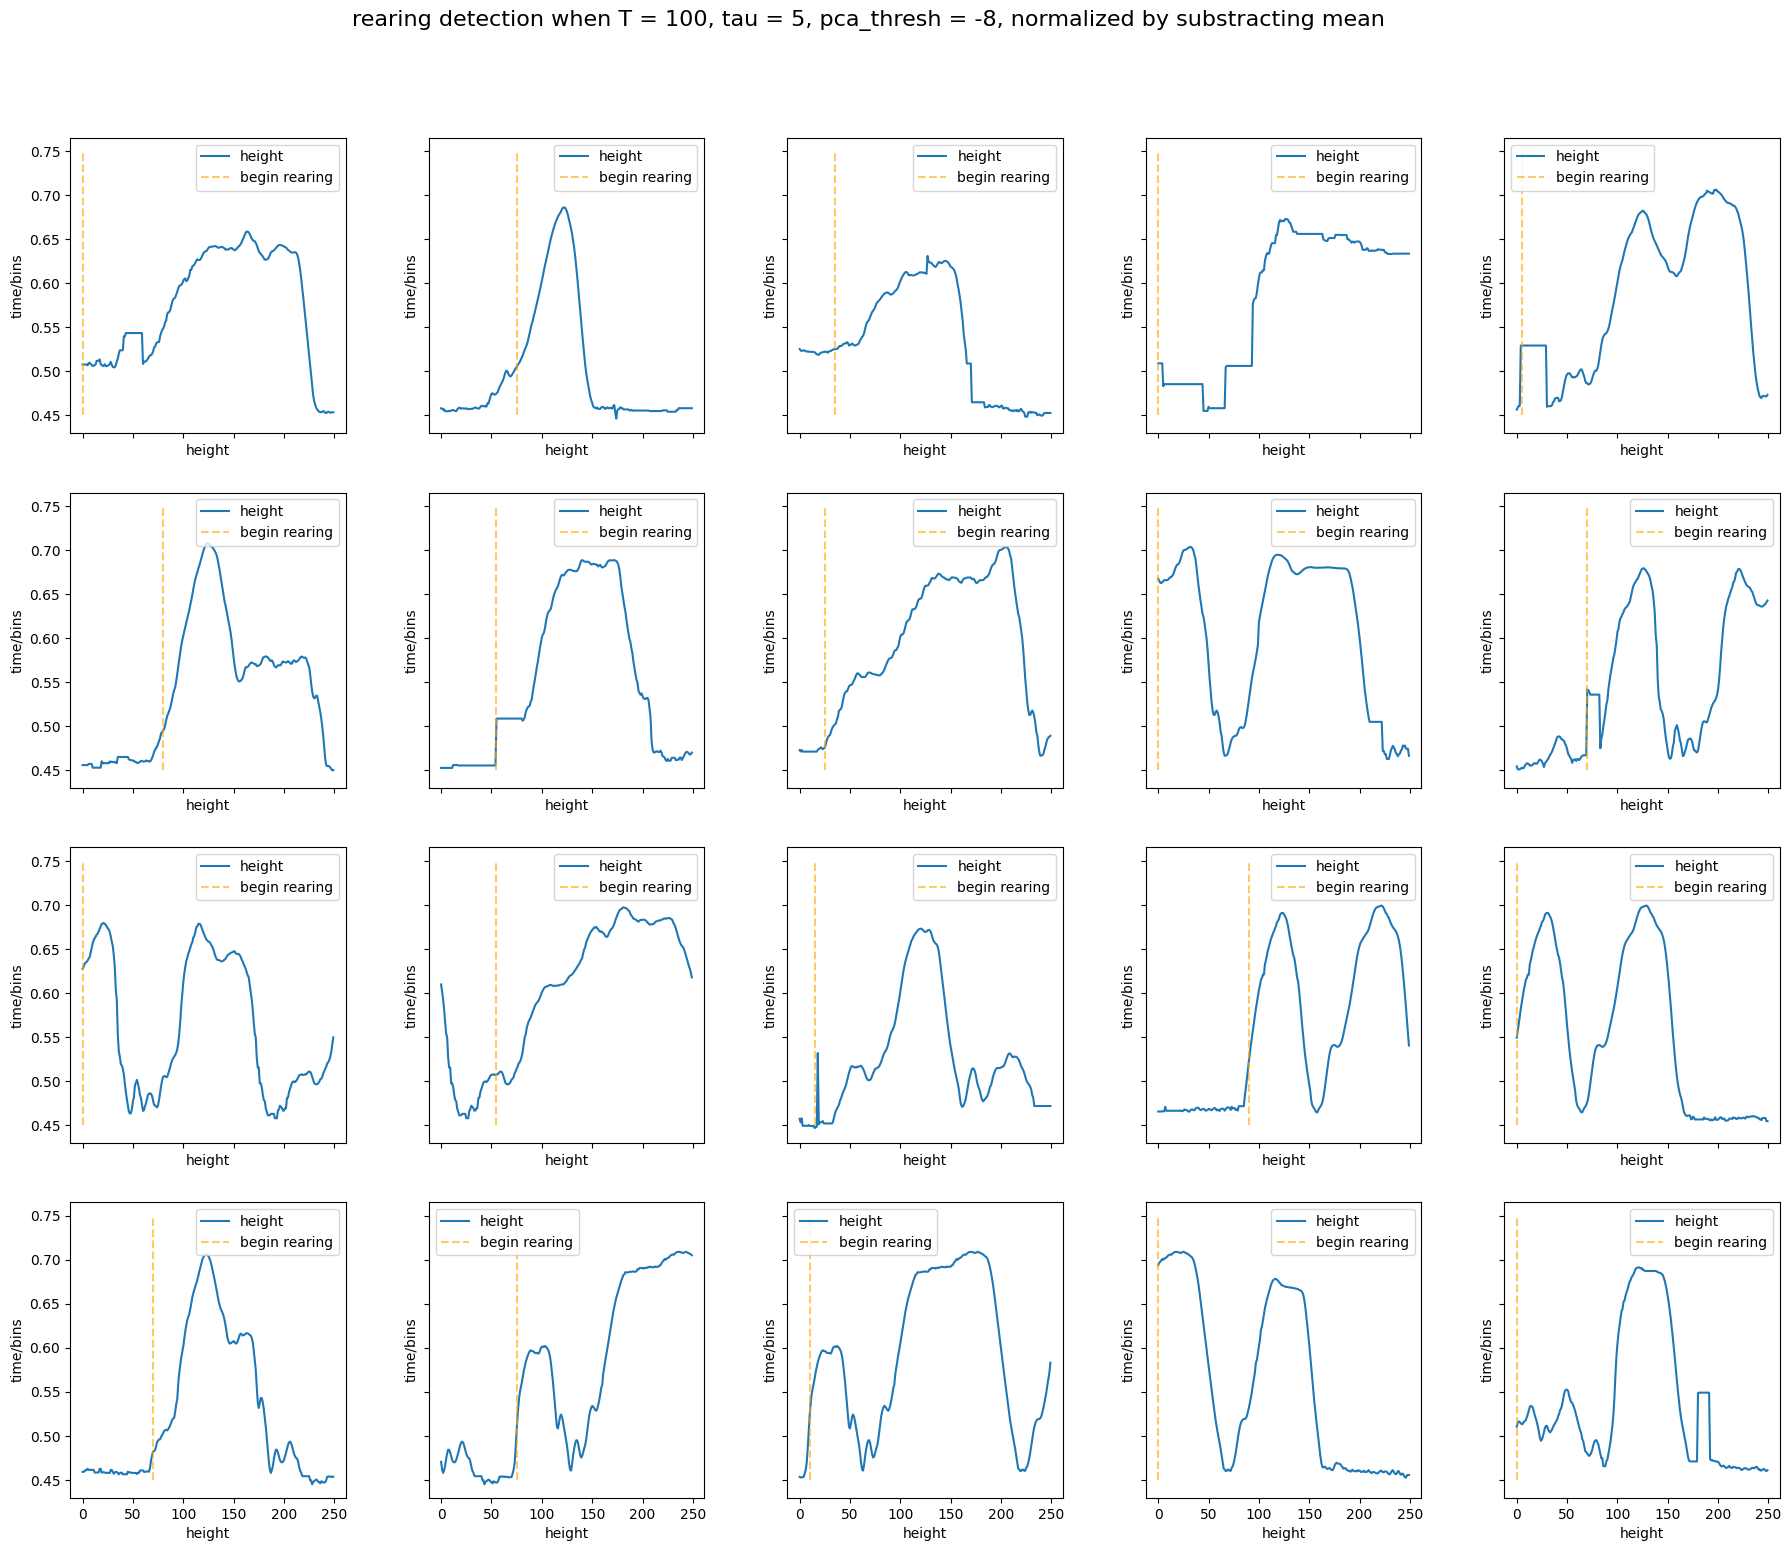

In [124]:
save_fig = True
fig, axis = plt.subplots(4,5, figsize = (19,16), sharey = True, sharex = True)
axis = axis.flatten()

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.90,
                    hspace=0.2, wspace=0.3)
begin_idx = 0

for i,event_id in enumerate(np.arange(begin_idx,begin_idx + 20)):
    axis[i].plot(longer_array[event_id,0,:],label = 'height')
    rearing_idx = min(np.argwhere(reshape_x[:,event_id]>=pca_thresh).reshape(-1)) * tau 
    axis[i].vlines(rearing_idx,ymin = 0.45, ymax = 0.75, label ='begin rearing', linestyles = 'dashed', color = 'orange', alpha = 0.6)
    axis[i].set_xlabel('height')
    axis[i].set_ylabel('time/bins')
    axis[i].legend()
title = 'rearing detection when T = %d, tau = %d, pca_thresh = %d, normalized by substracting mean'%(T, tau,pca_thresh)
fig.suptitle(title, fontsize = 16)
if save_fig == True:
    fig.savefig('results/PCA_method/%s/%s.png'%(rat_id, title), format ='png',)

# 3.3 find max eigenvalue by changing tau and T

100%|██████████| 6/6 [01:14<00:00, 12.36s/it]


Text(0.5, 0.98, 'first eigenvalue for different T, tau, only normalized by substract mean')

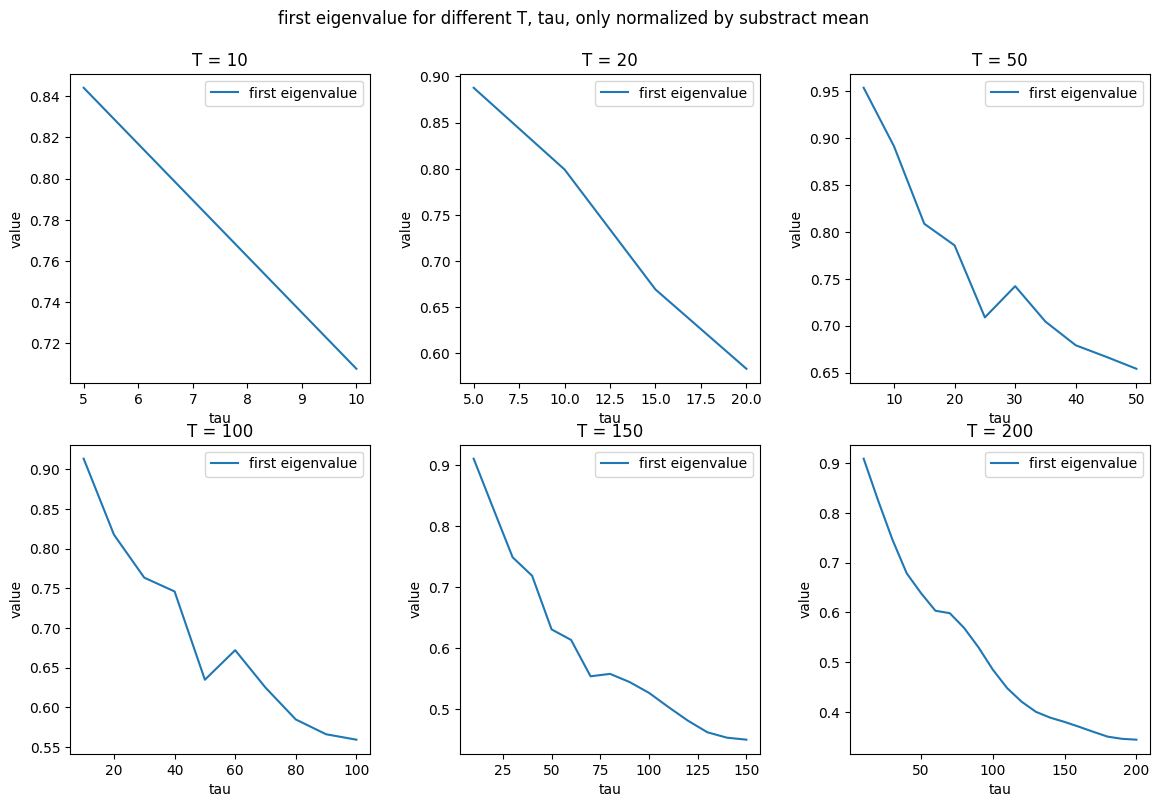

In [12]:
T_list = [10,20,50,100,150,200]
step_list = [5,5,5,10,10,10]

# plot the results
fig, axis = plt.subplots(2,3, figsize = (12,8))
axis = axis.flatten()
fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.90,
                    hspace=0.2, wspace=0.3)

all_eigen_values = []
all_eigen_vectors = []
i = -1
for this_T in tqdm(T_list):
    i+= 1 # indicate index of T_list
    tau_list = np.arange(step_list[i], this_T+1, step_list[i])

    # eigen_valuse from different tau in the tau_list
    eigen_values = []
    eigen_vectors = []

    for this_tau in tau_list:
        
        # for each rearing event, get T length time before it
        before_list = []
        for this_rearing in rearing_periods:
            begin_idx = this_rearing[0]
            if begin_idx - this_T >=0:
                before_list.append(all_feature_matrix[:,begin_idx - this_T: begin_idx])
        before_matrix = np.asarray(before_list) # in shape [num_event, k, T]
        
        x_matrix = generate_tau_sample(before_matrix, tau =this_tau, step = this_tau, T = this_T,k = 4)
        
        # normalize x_matrix
        x_norm = (x_matrix - x_matrix.mean(axis=0))
        pca = PCA(n_components= 10)
        pca.fit(x_norm)
        
        eigen_vec = pca.components_
        eigen_ratio = pca.explained_variance_ratio_
        
        eigen_values.append(eigen_ratio)
        eigen_vectors.append(eigen_vec)
    
    # plot the results
    ratio_array = np.asarray(eigen_values)
    axis[i].plot(tau_list, ratio_array[:,0],label='first eigenvalue')
    axis[i].set_xlabel('tau')
    axis[i].set_ylabel('value')
    axis[i].set_title('T = %d'%this_T)
    axis[i].legend()
    # for each T, save the resutls
    
    all_eigen_values.append(eigen_values)
    all_eigen_vectors.append(eigen_vectors)

fig.suptitle('first eigenvalue for different T, tau, only normalized by substract mean')



        

100%|██████████| 6/6 [00:00<00:00, 18.55it/s]


Text(0.5, 0.98, 'Score(projected on first eigenvector) with different T, tau; normalized by subtracting mean')

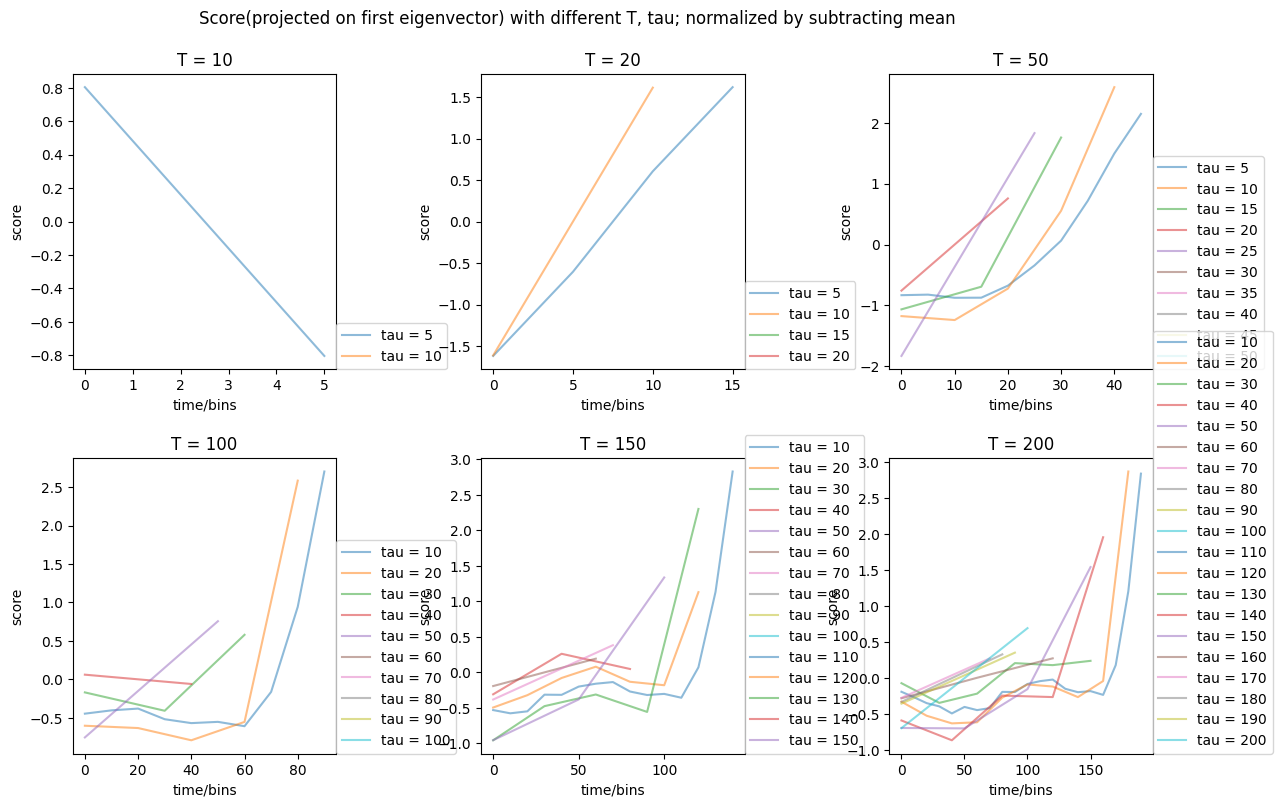

In [13]:
T_list = [10,20,50,100,150,200]
step_list = [5,5,5,10,10,10]

# plot the results
fig, axis = plt.subplots(2,3, figsize = (12,8))
axis = axis.flatten()
fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.90,
                    hspace=0.3, wspace=0.55)


i = -1
for this_T in tqdm(T_list):
    i+= 1 # indicate index of T_list
    tau_list = np.arange(step_list[i], this_T+1, step_list[i])

    # eigen_valuse from different tau in the tau_list
    eigen_values = all_eigen_values[i]
    eigen_vectors =  all_eigen_vectors[i]

    for j, this_tau in enumerate(tau_list): # only the first tau
        
        # for each rearing event, get T length time before it
        before_list = []
        for this_rearing in rearing_periods:
            begin_idx = this_rearing[0]
            if begin_idx - this_T >=0:
                before_list.append(all_feature_matrix[:,begin_idx - this_T: begin_idx])
        before_matrix = np.asarray(before_list) # in shape [num_event, k, T]
        num_events = before_matrix.shape[0] # number of rearing events
        
        x_matrix = generate_tau_sample(before_matrix, tau =this_tau, step = this_tau, T = this_T)
        
        # normalize x_matrix
        x_norm = (x_matrix - x_matrix.mean(axis=0))/np.std(x_matrix,axis = 0)
        
        eigen_vec = eigen_vectors[j] # shape of eigen_vec : [num_PC, length of each PC]
        eigen_ratio = eigen_values[j]
        
         # # calculate the score by projecting data on first eigen vectors
        proj_x = x_norm @ eigen_vec[0,:]
        reshape_x = np.reshape(proj_x,(-1, num_events))
        x_sem = sem(reshape_x, axis = 1)        
        
        

        # plot the results
        x = np.arange(0,int(this_T//this_tau))*this_tau

        ratio_array = np.asarray(eigen_values)
        axis[i].plot(x, reshape_x.mean(axis = 1),label='tau = %d'%this_tau, alpha = 0.5)
        # axis[i].fill_between(x, reshape_x.mean(axis = 1) + x_sem, reshape_x.mean(axis = 1)- x_sem, alpha = 0.5, label = 'sem')

        axis[i].set_xlabel('time/bins')
        axis[i].set_ylabel('score')
        axis[i].set_title('T = %d'%(this_T))
        axis[i].legend(loc = (1,0))
        
    # ratio_array = np.asarray(eigen_values)
    # axis[i].plot(tau_list, ratio_array[:,0],label='first eigenvalue')
    # axis[i].set_xlabel('tau')
    # axis[i].set_ylabel('value')
    # axis[i].set_title('T = %d'%this_T)
    # axis[i].legend()

   
fig.suptitle('Score(projected on first eigenvector) with different T, tau; normalized by subtracting mean')




        

Text(0.5, 0.98, 'first eigenvector when T = 50, tau = 10, normalized by substracting mean')

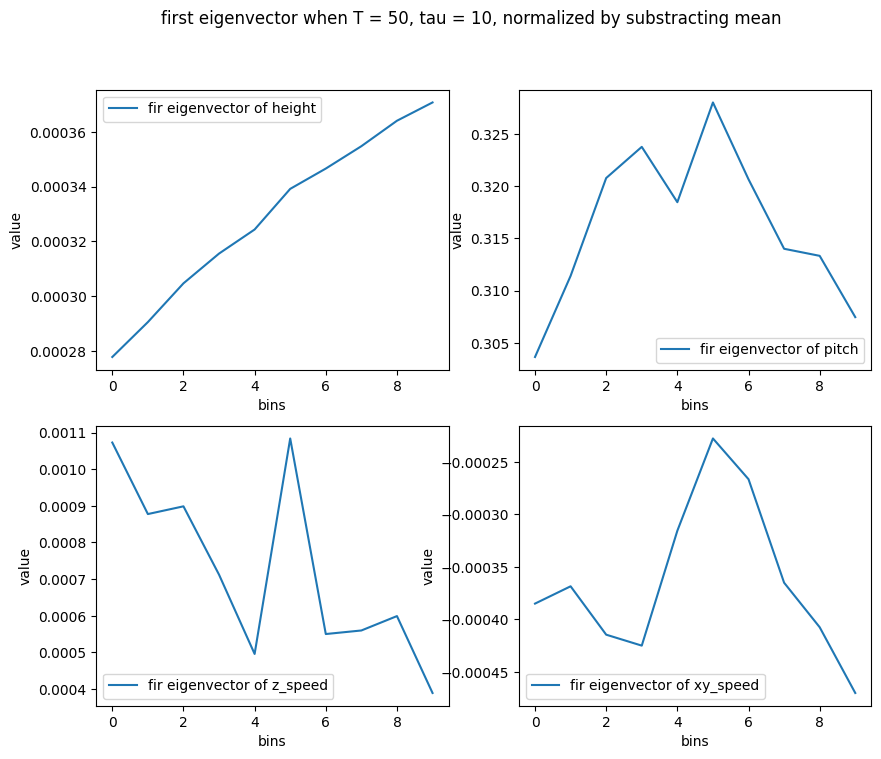

In [14]:

# Plot eigenvector resutls for first PC,

feature_labels = ['height', 'pitch','z_speed', 'xy_speed']
fig, axis = plt.subplots(2,2, figsize = (10,8))
axis = axis.flatten()
k = 4
firt_pc = np.split(all_eigen_vectors[2][1][0,:], k, axis = 0)

for i in np.arange(0,k):
   
    axis[i].plot(firt_pc[i],label = 'fir eigenvector of %s'%feature_labels[i])

    axis[i].legend()
    axis[i].set_xlabel('bins',)
    axis[i].set_ylabel('value')
fig.suptitle('first eigenvector when T = 50, tau = 10, normalized by substracting mean')

# 3.4 what do each eigenvector capture? 

In [39]:
this_tau = 200
this_T = 200

In [101]:
save_fig = True
steps_list = [[0.05,0.05],[0.0001,0.001]]

In [90]:
def plot_joint_distribution(fir_idx, sec_idx, x_norm, eigen_vec, interested_eigen, steps_list, save_fig = False, 
                            feature_labels = ['height', 'pitch','z_speed', 'xy_speed']):
    
    
    '''
    plot joint probability distribution for two features
    '''
    fig, axis = plt.subplots(2,2, figsize = (12,10))
    axis = axis.flatten()
    fir_feature = x_norm[:, fir_idx* this_tau: (fir_idx+1) * this_tau].reshape(-1)
    sec_feature = x_norm[:, sec_idx* this_tau: (sec_idx+1) * this_tau].reshape(-1)

    i = 0
    [x_line, y_line], joint_array = joint_density_function(fir_feature, sec_feature, steps = steps_list[0], set_max= False, set_min= False)

    heatmap = axis[i].imshow(np.log(joint_array), cmap = 'rainbow', interpolation='none', aspect='auto', extent=[x_line[0],x_line[-1],y_line[0],y_line[-1]])
    axis[i].set_xlabel('%s'%feature_labels[fir_idx])
    axis[i].set_ylabel('%s'% feature_labels[sec_idx])
    fig.colorbar(heatmap, ax =axis[i])
    axis[i].set_title('original data')


    interested_eigen = [0,1,2]

    for i in interested_eigen:
            reconstruc_x = x_norm @ (eigen_vec[i,:].reshape((-1,1)) @ eigen_vec[i,:].reshape((1,-1)))
            this_fir_feature = reconstruc_x[:, fir_idx* this_tau: (fir_idx+1) * this_tau].reshape(-1)
            this_sec_feature = reconstruc_x[:, sec_idx* this_tau: (sec_idx+1) * this_tau].reshape(-1)

            [this_xline, this_yline], this_joint_array = joint_density_function(this_fir_feature, this_sec_feature, steps = steps_list[1], set_max= False, set_min= False)
            
            this_heatmap = axis[i+1].imshow(np.log(this_joint_array), cmap = 'rainbow', interpolation='none',aspect='auto', extent=[this_xline[0],this_xline[-1],this_yline[0],this_yline[-1]])
            axis[i+1].set_xlabel('%s'%feature_labels[fir_idx])
            axis[i+1].set_ylabel('%s'% feature_labels[sec_idx])
            fig.colorbar(this_heatmap, ax =axis[i+1])
            axis[i+1].set_title('reconstructed data on %d PC'%(i+1))

    this_title = 'Joint distribution of %s and %s when T = %d tau = %d'%(feature_labels[fir_idx], feature_labels[sec_idx], this_T, this_tau)
    fig.suptitle(this_title)
    if save_fig == True:
            fig.savefig('results/PCA_method/%s/%s.png'%(rat_id, this_title), format ='png',)
    

In [ ]:
T_list = [10,20,50,100,150,200]
step_list = [5,5,5,10,10,10]

# # plot the results
# fig, axis = plt.subplots(2,3, figsize = (12,8))
# axis = axis.flatten()
# fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.90,
#                     hspace=0.3, wspace=0.55)


i = -1
for this_T in tqdm(T_list):
    i+= 1 # indicate index of T_list
    tau_list = np.arange(step_list[i], this_T+1, step_list[i])

    # eigen_valuse from different tau in the tau_list
    eigen_values = all_eigen_values[i]
    eigen_vectors =  all_eigen_vectors[i]

    for j, this_tau in enumerate(tau_list): # only the first tau
        
        # for each rearing event, get T length time before it
        before_list = []
        for this_rearing in rearing_periods:
            begin_idx = this_rearing[0]
            if begin_idx - this_T >=0:
                before_list.append(all_feature_matrix[:,begin_idx - this_T: begin_idx])
        before_matrix = np.asarray(before_list) # in shape [num_event, k, T]
        num_events = before_matrix.shape[0] # number of rearing events
        
        x_matrix = generate_tau_sample(before_matrix, tau =this_tau, step = this_tau, T = this_T)
        
        # normalize x_matrix
        x_norm = (x_matrix - x_matrix.mean(axis=0))/np.std(x_matrix,axis = 0)
        
        eigen_vec = eigen_vectors[j] # shape of eigen_vec : [num_PC, length of each PC]
        eigen_ratio = eigen_values[j]
        
         # # calculate the score by projecting data on first eigen vectors
        plot_joint_distribution(0,2,x_norm= x_norm,eigen_vec= eigen_vec, interested_eigen=[0,1,2], steps_list=steps_list, save_fig= True)
        
    # ratio_array = np.asarray(eigen_values)
    # axis[i].plot(tau_list, ratio_array[:,0],label='first eigenvalue')
    # axis[i].set_xlabel('tau')
    # axis[i].set_ylabel('value')
    # axis[i].set_title('T = %d'%this_T)
    # axis[i].legend()

   
# fig.suptitle('Score(projected on first eigenvector) with different T, tau; normalized by subtracting mean')




        

/var/folders/rm/m418549n60ldjvfgbchrnp8r0000gn/T/ipykernel_77662/254772844.py:20: RuntimeWarning: divide by zero encountered in log
  heatmap = axis[i].imshow(np.log(joint_array), cmap = 'rainbow', interpolation='none', aspect='auto', extent=[x_line[0],x_line[-1],y_line[0],y_line[-1]])
/var/folders/rm/m418549n60ldjvfgbchrnp8r0000gn/T/ipykernel_77662/254772844.py:36: RuntimeWarning: divide by zero encountered in log
  this_heatmap = axis[i+1].imshow(np.log(this_joint_array), cmap = 'rainbow', interpolation='none',aspect='auto', extent=[this_xline[0],this_xline[-1],this_yline[0],this_yline[-1]])


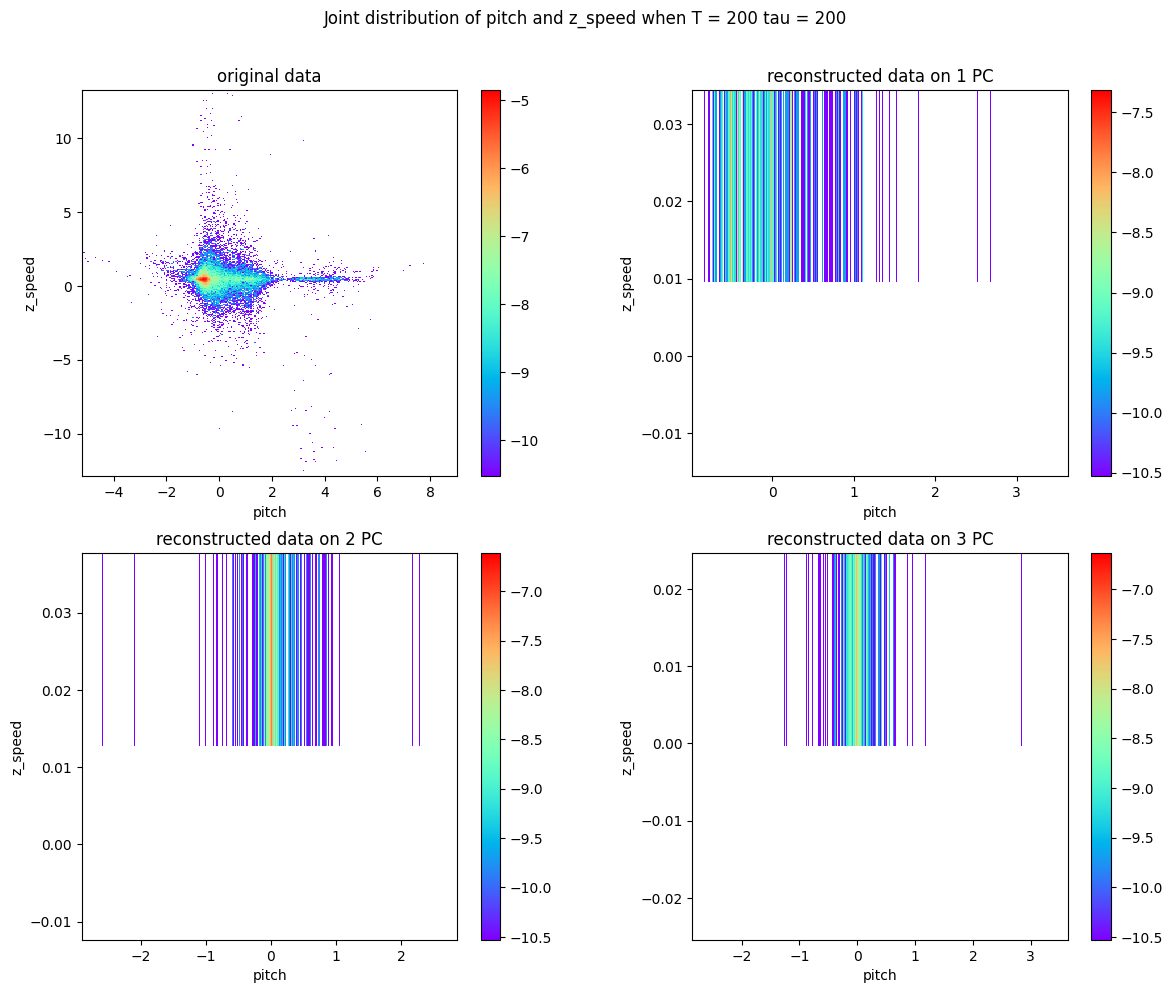

In [99]:
# calculate the joint probability distribution of two variables
fir_idx, sec_idx = int(1),int(2) # height, pitch
fir_feature = x_norm[:, fir_idx* this_tau: (fir_idx+1) * this_tau].reshape(-1)
sec_feature = x_norm[:, sec_idx* this_tau: (sec_idx+1) * this_tau].reshape(-1)


feature_labels = ['height', 'pitch','z_speed', 'xy_speed']
fig, axis = plt.subplots(2,2, figsize = (12,10))
axis = axis.flatten()
vmaxs = [0.8,120,1,1.5]
vmins = [0.4,-120,-1,0]


fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.90,hspace=0.2, wspace=0.3)

i = 0

[x_line, y_line], joint_array = joint_density_function(fir_feature, sec_feature, steps = [0.05, 0.05], set_max= False, set_min= False)

heatmap = axis[i].imshow(np.log(joint_array), cmap = 'rainbow', interpolation='none', aspect='auto', extent=[x_line[0],x_line[-1],y_line[0],y_line[-1]])
axis[i].set_xlabel('%s'%feature_labels[fir_idx])
axis[i].set_ylabel('%s'% feature_labels[sec_idx])
fig.colorbar(heatmap, ax =axis[i])
axis[i].set_title('original data')


interested_eigen = [0,1,2]

for i in interested_eigen:
        reconstruc_x = x_norm @ (eigen_vec[i,:].reshape((-1,1)) @ eigen_vec[i,:].reshape((1,-1)))
        this_fir_feature = reconstruc_x[:, fir_idx* this_tau: (fir_idx+1) * this_tau].reshape(-1)
        this_sec_feature = reconstruc_x[:, sec_idx* this_tau: (sec_idx+1) * this_tau].reshape(-1)

        [this_xline, this_yline], this_joint_array = joint_density_function(this_fir_feature, this_sec_feature, steps = [0.0001, 0.05], set_max= False, set_min= False)
        
        this_heatmap = axis[i+1].imshow(np.log(this_joint_array), cmap = 'rainbow', interpolation='none',aspect='auto', extent=[this_xline[0],this_xline[-1],this_yline[0],this_yline[-1]])
        axis[i+1].set_xlabel('%s'%feature_labels[fir_idx])
        axis[i+1].set_ylabel('%s'% feature_labels[sec_idx])
        fig.colorbar(this_heatmap, ax =axis[i+1])
        axis[i+1].set_title('reconstructed data on %d PC'%(i+1))

this_title = 'Joint distribution of %s and %s when T = %d tau = %d'%(feature_labels[fir_idx], feature_labels[sec_idx], this_T, this_tau)
fig.suptitle(this_title)
if save_fig == True:
        fig.savefig('results/PCA_method/%s/%s.png'%(rat_id, this_title), format ='png',)
